In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [15]:
# load metrics
data = np.load("metrics.npz")
train_losses = data['train_losses']
train_accuracies = data['train_accuracies']

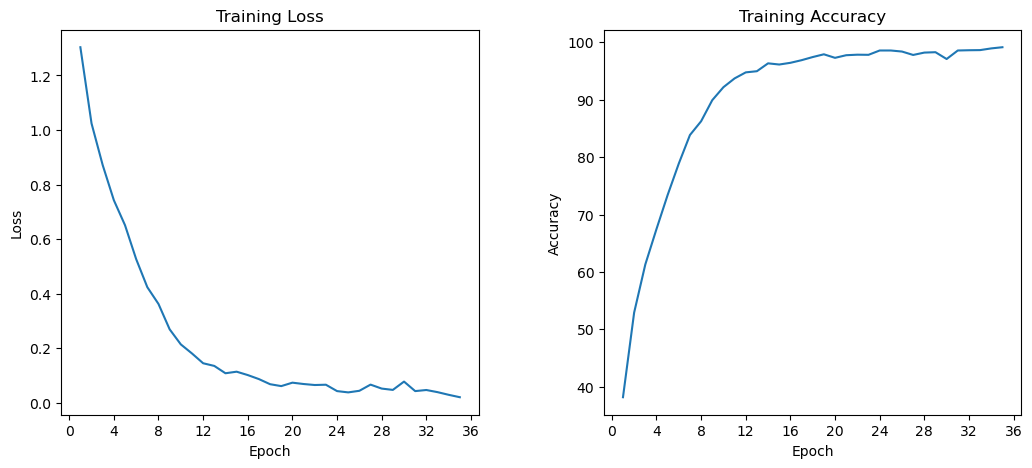

In [ ]:
epoch = [i + 1 for i in range(35)]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss
axes[0].plot(epoch, train_losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Plot accuracy
axes[1].plot(epoch, train_accuracies)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Accuracy')
axes[1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.show()